In [1]:
import sys
sys.path.append('..')
from data_utils import *

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from transformer import *
import importlib

import wandb
import pickle
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

from transformer import *
from utils import *
from hybrid_loss import *

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

In [2]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (180000, 20000, 0)


In [41]:
merge_tols = [0, 1, 2, 3, 4, 5]

In [10]:
device = 'cuda'
transformer = TransformerModel()
transformer.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_28_70.pth", weights_only=False)
transformer.load_state_dict(checkpoint['model_state_dict'])
transformer.eval()

unet = UNet1D()
unet.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/unet_2_2_35epochs.pth", weights_only=False)
unet.load_state_dict(checkpoint['model_state_dict'])
unet.eval()

UNet1D(
  (encoders): ModuleList(
    (0): Sequential(
      (0): ResidualBlock1D(
        (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock1D(
        (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): ResidualBlock1D(
        (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), p

In [43]:
from hybrid_loss import *

results = dict()
results['tr_acc'] = []
results['tr_purity'] = []
results['tr_interval'] = []
results['tr_int_rmse'] = []
results['unet_acc'] = []
results['unet_purity'] = []
results['unet_interval'] = []
results['unet_int_rmse'] = []

for tol in merge_tols:

    epochs = 1
    epoch = 0
    
    acc_progress = tqdm(val_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)
    waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(val_loader))
    
    # Accumulators for UNet
    unet_merge_acc = 0.0
    unet_merge_pure = 0.0
    
    # Accumulators for Transformer
    trans_merge_acc = 0.0
    trans_merge_pure = 0.0
    
    unet_interval_bins = []
    trans_interval_bins = []
    
    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # [B, 1, 16000]
    
            # Forward passes
            unet_class_output, unet_reg_output = unet(data, mode='bce')
            trans_class_output, trans_reg_output = transformer(data, mode='bce')
    
            # Masks for merged evaluation
            unet_merged_mask = merge_bins(unet_class_output, skip_tol=tol)
            trans_merged_mask = merge_bins(trans_class_output, skip_tol=tol)
    
            # Interval widths (UNet)
            for b in range(unet_merged_mask.shape[0]):
                mask_row = unet_merged_mask[b, 0]  # [L]
                intervals = mask_to_intervals(mask_row)
                widths = [(e - s + 1) for (s, e) in intervals]
                unet_interval_bins.extend(widths)
    
            # Interval widths (Transformer)
            for b in range(trans_merged_mask.shape[0]):
                mask_row = trans_merged_mask[b, 0]
                intervals = mask_to_intervals(mask_row)
                widths = [(e - s + 1) for (s, e) in intervals]
                trans_interval_bins.extend(widths)

            # Summed Photons per Interval
            unet_interval_pred_sums = sum_photons_in_intervals(torch.exp(unet_reg_output), unet_merged_mask)
            unet_interval_true_sums = sum_photons_in_intervals(photon_target, unet_merged_mask)
            trans_interval_pred_sums = sum_photons_in_intervals(torch.exp(trans_reg_output), trans_merged_mask)
            trans_interval_true_sums = sum_photons_in_intervals(photon_target, trans_merged_mask)

            rmse_unet = interval_rmse(unet_interval_pred_sums, unet_interval_true_sums)
            rmse_trans = interval_rmse(trans_interval_pred_sums, trans_interval_true_sums)
    
            # ---- UNet stats ----
            unet_merge_acc += merged_class_acc(unet_merged_mask, hit_times, device)
            unet_merge_pure += merged_class_purity(unet_merged_mask, hit_times, device)
    
            # ---- Transformer stats ----
            trans_merge_acc += merged_class_acc(trans_merged_mask, hit_times, device)
            trans_merge_pure += merged_class_purity(trans_merged_mask, hit_times, device)
    
    # Compute avg interval widths once at the end
    avg_unet_interval = np.mean(unet_interval_bins) if unet_interval_bins else 0.0
    avg_trans_interval = np.mean(trans_interval_bins) if trans_interval_bins else 0.0
    
    # ---- Average across batches ----
    N = len(val_loader)
    
    unet_merge_acc /= N
    unet_merge_pure /= N
    
    trans_merge_acc /= N
    trans_merge_pure /= N

    rmse_unet /= N
    rmse_trans /= N

    results['tr_acc'].append(trans_merge_acc)
    results['tr_purity'].append(trans_merge_pure)
    results['tr_interval'].append(avg_trans_interval)
    results['tr_int_rmse'].append(rmse_trans)
    results['unet_acc'].append(unet_merge_acc)
    results['unet_purity'].append(unet_merge_pure)
    results['unet_interval'].append(avg_unet_interval)
    results['unet_int_rmse'].append(rmse_unet)

np.save("merge_study_closed.npy", results, allow_pickle=True)

KeyboardInterrupt: 

In [6]:
print(results.keys())
print(results)

dict_keys(['tr_acc', 'tr_purity', 'tr_interval', 'tr_int_rmse', 'unet_acc', 'unet_purity', 'unet_interval', 'unet_int_rmse'])
{'tr_acc': [0.9619325000000002, 0.96196375, 0.9619708928571429, 0.9620164285714286, 0.9620476785714284, 0.9621085714285713], 'tr_purity': [0.704728714586067, 0.7130467523081502, 0.7206932173667835, 0.7295917342869551, 0.7383793734288586, 0.7479511600205359], 'tr_interval': [np.float64(22.089567657364622), np.float64(22.382057570125163), np.float64(22.665768733342386), np.float64(23.019695807585997), np.float64(23.399393348817103), np.float64(23.813728472742653)], 'tr_int_rmse': [0.1133292459340855, 0.11425501709232105, 0.11457098192033337, 0.11457098192033337, 0.1152056794574759, 0.11553302239656237], 'unet_acc': [0.9294098214285711, 0.9301510714285709, 0.9305050595238089, 0.9308698809523801, 0.9311692261904756, 0.9312704761904754], 'unet_purity': [0.9236110584938784, 0.9529337015762022, 0.9619727976190474, 0.9703166865079367, 0.9759573214285717, 0.9788362103174

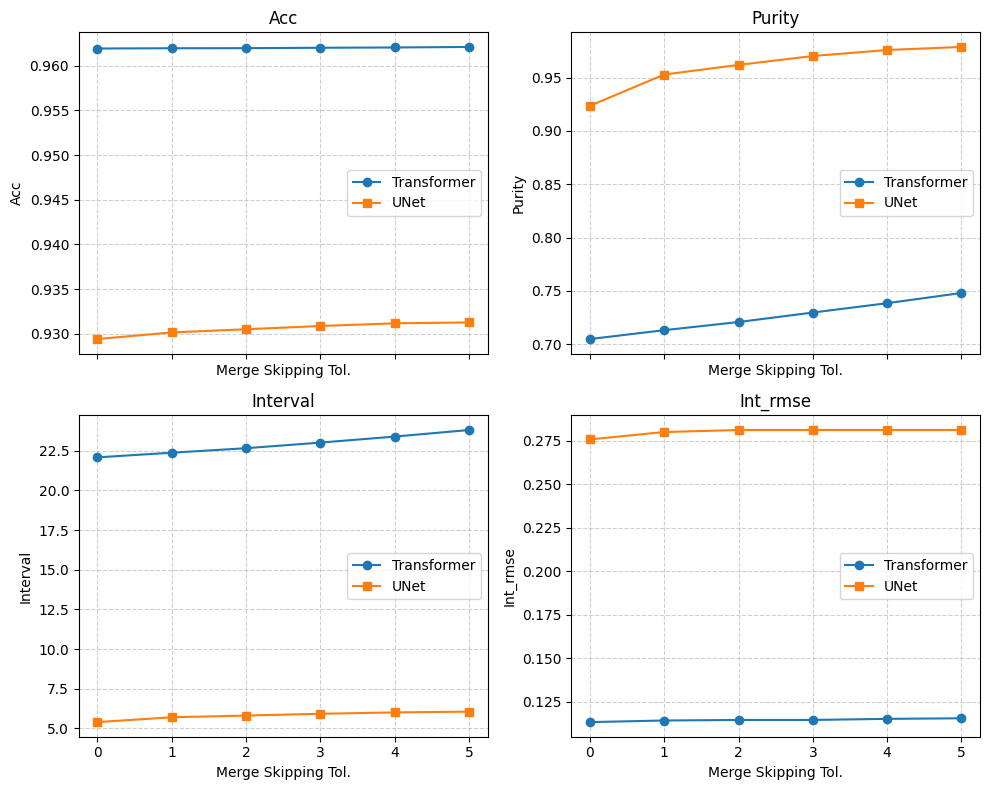

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define quantities to plot
quantities = ["acc", "purity", "interval", 'int_rmse']

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()
for ax, q in zip(axes, quantities):
    ax.plot(merge_tols, results[f"tr_{q}"][:len(merge_tols)], marker="o", label="Transformer")
    ax.plot(merge_tols, results[f"unet_{q}"][:len(merge_tols)], marker="s", label="UNet")
    ax.set_title(q.capitalize())
    ax.set_xlabel("Merge Skipping Tol.")
    ax.set_xticks(merge_tols)
    ax.set_ylabel(q.capitalize())
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [11]:
def plot_sample_intervals(waveform, intervals, pred_sums, true_sums, title="Interval RMSE Example"):
    """
    waveform: [L] numpy array of signal
    intervals: list of (start, end) index tuples for merged intervals
    pred_sums: list of predicted photons per interval
    true_sums: list of true photons per interval
    """
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Top panel: waveform with interval boundaries
    axs[0].plot(waveform, color="blue", lw=1, label="Waveform")
    for (s, e) in intervals:
        axs[0].axvspan(s, e, color="mediumseagreen", alpha=0.5)
    axs[0].set_ylabel("Normalized Amplitude")
    axs[0].legend()
    axs[0].set_title(title)

    # Bottom panel: photon bar chart
    centers = [(s + e) / 2 for (s, e) in intervals]  # place bar at interval center
    # width = [(e - s + 1)*5 for (s, e) in intervals]      # bar width = interval size
    width = 50
    offset = width / 2
    true_centers = [c - offset/2 for c in centers]
    pred_centers = [c + offset/2 for c in centers]
 

    axs[1].bar(true_centers, true_sums, width=width/2, alpha=0.8, label="True", align="center")
    axs[1].bar(pred_centers, pred_sums, width=width/2, alpha=0.8, label="Pred", align="center")
    axs[1].set_ylabel("Summed Photons")
    axs[1].set_xlabel("Time Bins")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [12]:
epochs = 1
epoch = 0

acc_progress = tqdm(val_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(val_loader))

# Forward passes
unet_class_output, unet_reg_output = unet(waveforms.to(device), mode='bce')
trans_class_output, trans_reg_output = transformer(waveforms.to(device), mode='bce')

# Masks for merged evaluation
unet_merged_mask = merge_bins(unet_class_output, skip_tol=5)
trans_merged_mask = merge_bins(trans_class_output, skip_tol=5)

# Interval widths (UNet)
for b in range(unet_merged_mask.shape[0]):
    mask_row = unet_merged_mask[b, 0]  # [L]
    intervals = mask_to_intervals(mask_row)
    widths = [(e - s + 1) for (s, e) in intervals]
    unet_interval_bins.extend(widths)

# Interval widths (Transformer)
for b in range(trans_merged_mask.shape[0]):
    mask_row = trans_merged_mask[b, 0]
    intervals = mask_to_intervals(mask_row)
    widths = [(e - s + 1) for (s, e) in intervals]
    trans_interval_bins.extend(widths)

# Summed Photons per Interval
unet_interval_pred_sums = sum_photons_in_intervals(torch.exp(unet_reg_output), unet_merged_mask)
unet_interval_true_sums = sum_photons_in_intervals(photon_bins, unet_merged_mask)
trans_interval_pred_sums = sum_photons_in_intervals(torch.exp(trans_reg_output), trans_merged_mask)
trans_interval_true_sums = sum_photons_in_intervals(photon_bins, trans_merged_mask)

b = 2  # pick a single sample index
waveform = waveforms[b, 0].cpu().numpy()
mask_row = trans_merged_mask[b, 0]
intervals = mask_to_intervals(mask_row)

pred_sums = trans_interval_pred_sums[b]
true_sums = trans_interval_true_sums[b]

plot_sample_intervals(waveform, intervals, pred_sums, true_sums, title=f"Trans Interval RMSE: {rmse_unet:.3f}")

Scanning 1/1:   0%|          | 0/800 [00:00<?, ?it/s]

NameError: name 'unet_interval_bins' is not defined

### Separation Study

In [13]:
sep_values = np.array([50, 100, 300, 500, 700, 900, 1100])
sep_results = dict()
sep_results = {str(s): [] for s in sep_values}

load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/separation_study.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

batch_size = 25 # 400 batches per value
device = 'cuda'

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(np.array(hit_times))
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

sep_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

epoch = 0
epochs = 1

acc_progress = tqdm(sep_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

# Accumulators for Transformer
trans_merge_acc = 0.0
trans_merge_pure = 0.0
rmse_trans = 0.0

trans_interval_bins = []

with torch.no_grad():
    for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
        data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # [B, 1, 16000]

        # Forward passes
        trans_class_output, trans_reg_output = transformer(data, mode='bce')
    
        # Masks for merged evaluation
        trans_merged_mask = merge_bins(trans_class_output, skip_tol=5)
    
        # Interval widths (Transformer)
        for b in range(trans_merged_mask.shape[0]):
            mask_row = trans_merged_mask[b, 0]
            intervals = mask_to_intervals(mask_row)
            widths = [(e - s + 1) for (s, e) in intervals]
            trans_interval_bins.extend(widths)

            # Summed Photons per Interval
            # trans_interval_pred_sums = sum_photons_in_intervals_vec(torch.exp(trans_reg_output), trans_merged_mask)
            # trans_interval_true_sums = sum_photons_in_intervals_vec(photon_target, trans_merged_mask)
            # rmse_trans += interval_rmse(trans_interval_pred_sums, trans_interval_true_sums)
    
            # ---- Transformer stats ----
            trans_merge_acc += merged_class_acc(trans_merged_mask, hit_times, device)
            trans_merge_pure += merged_class_purity(trans_merged_mask, hit_times, device)
    
        # Compute stats per separation
        if ((i+1) % 400 == 0):
            avg_trans_interval = np.mean(trans_interval_bins) if trans_interval_bins else 0.0
            N = 400 * 25
            
            sep_key = str(sep_values[i // 400])  # set current_sep_index properly
            sep_results[sep_key] = [trans_merge_acc/N, trans_merge_pure/N, rmse_trans/N, avg_trans_interval]
            print(sep_results[sep_key])
            trans_merge_acc, trans_merge_pure, rmse_trans = 0.0, 0.0, 0.0
            trans_interval_bins = []
            print("reset")

np.save("sep_results.npy", sep_results, allow_pickle=True)

Scanning 1/1:  14%|█▍        | 400/2800 [01:28<08:50,  4.52it/s]

[1.0, 1.8562666666665348, 0.0, np.float64(92.71576384662204)]
reset


Scanning 1/1:  29%|██▊       | 800/2800 [02:56<07:21,  4.53it/s]

[0.999499999999996, 0.7444366666666655, 0.0, np.float64(30.827782693328615)]
reset


Scanning 1/1:  43%|████▎     | 1200/2800 [04:22<05:48,  4.59it/s]

[0.9977499999999759, 0.7818838095238226, 0.0, np.float64(22.99562363238512)]
reset


Scanning 1/1:  57%|█████▋    | 1600/2800 [05:47<04:13,  4.74it/s]

[0.9998499999999978, 0.9111719047618557, 0.0, np.float64(13.416180948238365)]
reset


Scanning 1/1:  71%|███████▏  | 2000/2800 [07:12<02:50,  4.69it/s]

[0.99995, 0.8909369047618649, 0.0, np.float64(13.638528867194076)]
reset


Scanning 1/1:  86%|████████▌ | 2400/2800 [08:37<01:25,  4.71it/s]

[1.0, 0.8833752380952093, 0.0, np.float64(13.649157829070493)]
reset


[1.0, 0.8854223809523495, 0.0, np.float64(13.174783188792528)]
reset


[1.      0.9995  0.99775 0.99985 0.99995 1.      1.     ]


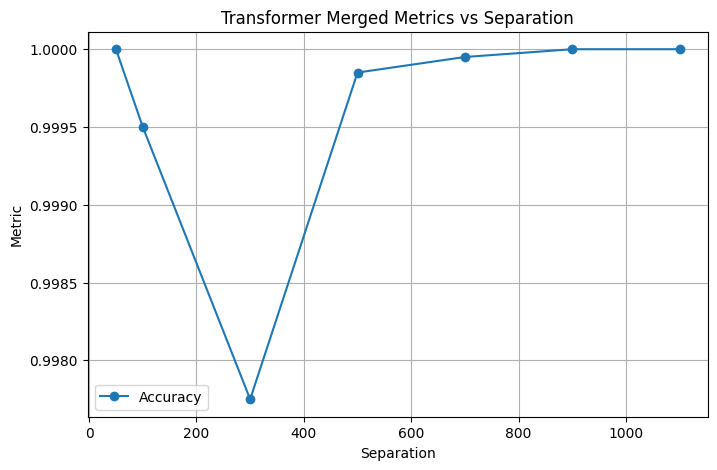

In [14]:
import matplotlib.pyplot as plt

# Extract keys in numeric order
sep_results = np.load('sep_results.npy', allow_pickle=True).item()
sep_keys = sorted(sep_results.keys(), key=lambda x: int(x))  # ['50', '100', '300', ...]

# Extract accuracies
accuracies = np.array([sep_results[k][0] for k in sep_keys]) # index 0 = trans_merge_acc/N
print(accuracies)

# Optionally extract other stats
purities = np.array([sep_results[k][1] for k in sep_keys])
rmse_vals = np.array([sep_results[k][2] for k in sep_keys])

# Convert keys to numbers for x-axis
x_vals = [int(k) for k in sep_keys]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_vals, accuracies, marker='o', label='Accuracy')
plt.xlabel('Separation')
# plt.xticks(x_vals)
plt.ylabel('Metric')
plt.title('Transformer Merged Metrics vs Separation')
plt.legend()
plt.grid(True)
plt.show()

# plt.plot(x_vals, purities, marker='s', label='Purity')


In [7]:
print(len(sep_loader))

2800


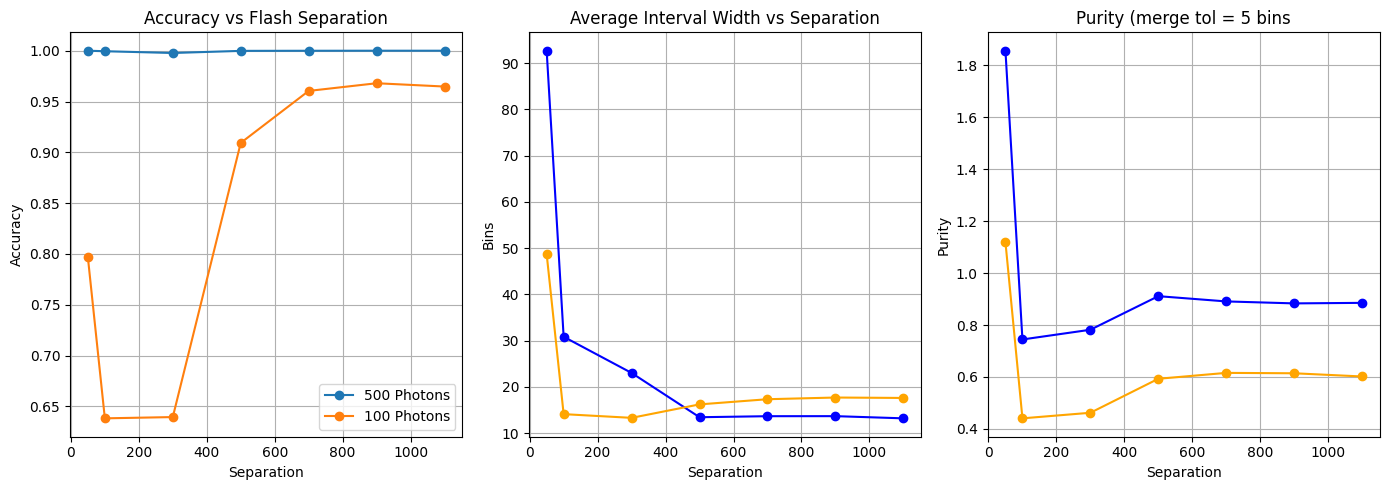

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics
sep_results = np.load('sep_results.npy', allow_pickle=True).item()
sep_results_100 = np.load('sep_results_100.npy', allow_pickle=True).item()
sep_keys = sorted(sep_results.keys(), key=lambda x: int(x))
x_vals = [int(k) for k in sep_keys]

accuracies = np.array([sep_results[k][0] for k in sep_keys])
accuracies_100 = np.array([sep_results_100[k][0] for k in sep_keys])
purities   = np.array([sep_results[k][1] for k in sep_keys])
purities_100   = np.array([sep_results_100[k][1] for k in sep_keys])
avg_intervals = np.array([sep_results[k][3] for k in sep_keys])
avg_intervals_100 = np.array([sep_results_100[k][3] for k in sep_keys])

# Create side-by-side subplots
fig, axs = plt.subplots(1, 3, figsize=(14,5))

# Left panel: Accuracy and Purity
axs[0].plot(x_vals, accuracies, marker='o', label='500 Photons')
axs[0].plot(x_vals, accuracies_100, marker='o', label='100 Photons')
# axs[0].plot(x_vals, purities, marker='s', label='Purity')
axs[0].set_xlabel('Separation')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Flash Separation')
axs[0].legend()
axs[0].grid(True)

# Right panel: Average interval width
axs[1].plot(x_vals, avg_intervals, marker='o', color='blue', label='500 Photons')
axs[1].plot(x_vals, avg_intervals_100, marker='o', color='orange', label='100 Photons')
axs[1].set_xlabel('Separation')
axs[1].set_ylabel('Bins')
axs[1].set_title('Average Interval Width vs Separation')
axs[1].grid(True)

# Right panel: Average interval width
axs[2].plot(x_vals, purities, marker='o', color='blue', label='500 Photons')
axs[2].plot(x_vals, purities_100, marker='o', color='orange', label='100 Photons')
axs[2].set_xlabel('Separation')
axs[2].set_ylabel('Purity')
axs[2].set_title('Purity (merge tol = 5 bins')
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [24]:
acc_progress = tqdm(sep_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)


Scanning 1/1:   0%|          | 0/2800 [00:00<?, ?it/s]

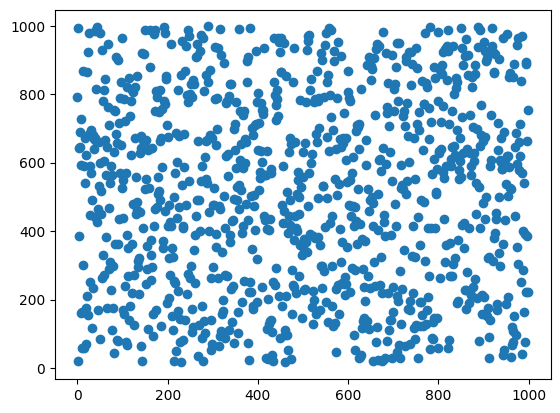

In [19]:
random_data = np.random.randint(10, 1000, size=1000)
ticks = np.arange(0, 1000)
plt.scatter(ticks, random_data)